This exploring notebook serves to get a better intuition of how the parameters passed to `pycbc.waveform.get_td_waveform`, namely `sample_rate`, `f_lower`, and `mass1` and `mass2` affect the generated waveforms.

In [ ]:
from pycbc.waveform import get_td_waveform
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def gen_data_strain(config):
    hp, hc = get_td_waveform(
        approximant=config["approximant"],
        mass1=config["mass1"],
        mass2=config["mass2"],
        distance=config["distance"],
        inclination=config["inclination"],
        f_lower=config["freq_lower"],
        delta_t=1.0 / config["sample_rate"],
    )
    return hp, hc

In [ ]:
config = {
    'approximant': "IMRPhenomPv2",
    'mass1': 2.0,
    'mass2': 2.0,
    'distance': 100,
    'inclination': 0.0,
    'sample_rate': 1024,
    'freq_lower': None
}

Here, we compare different masses.

In [ ]:
config['mass1'], config['mass2'] = 2.0, 2.0
config['sample_rate'] = 1024 * 8
config['freq_lower'] = 100
hp1, _ = gen_data_strain(config)

In [ ]:
config['mass1'], config['mass2'] = 1.0, 1.0
config['sample_rate'] = 1024 * 8
config['freq_lower'] = 100
hp2, _ = gen_data_strain(config)

In [ ]:
len(hp1), len(hp2)

(32768, 131072)

Waveforms from lower masses are longer in duration.  
We want to optimize the `f_lower` parameter, that is, increase it to speed up waveform generation. 
The worst case, i.e., where we risk not having enough samples fo fill our desired window, is when we consider the higher masses.

**Conclusion:** for lower masses, we can increase the `f_lower` frequency.

Now we test a different sample rate, also using the maximum and minimum masses.

In [ ]:
config['mass1'], config['mass2'] = 2.0, 2.0
config['sample_rate'] = 1024
config['freq_lower'] = 100
hp3, _ = gen_data_strain(config)

In [ ]:
config['mass1'], config['mass2'] = 1.0, 1.0
config['sample_rate'] = 1024
config['freq_lower'] = 100
hp4, _ = gen_data_strain(config)

In [ ]:
len(hp3), len(hp4)

(4096, 16384)

In [ ]:
len(hp1) / len(hp3)

8.0

The length of a waveform with 8 times the sample rate (all other variables constant) is 8 times higher.

In [ ]:
for hp in (hp1, hp2, hp3, hp4):
    print(hp.sample_times[0], np.round(hp.sample_times[-1], 2))

-3.8 0.2
-15.8 0.2
-3.8 0.2
-15.8 0.2


_Note:_ -3.8 means 3.8 seconds before merger. 0.2 means 0.2 seconds after merger.  

We can see that we are starting the simulation way too soon, as we have, respectively, 4 seconds and 16 seconds of data, for the higher and lower masses.  
Waveforms with the same mass but different sample rates start and end at the same time.

Now, let's test different `f_lower` values.

In [ ]:
config = {
    'approximant': "IMRPhenomPv2",
    'mass1': 2.0,
    'mass2': 2.0,
    'distance': 100,
    'inclination': 0.0,
    'sample_rate': 1024,
    'freq_lower': None
}

In [ ]:
config['sample_rate'] = 1024
freqs = np.linspace(10, 100, 10)
freqs

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [ ]:
hps = []
for freq in freqs:
    config['freq_lower'] = freq
    hp, _ = gen_data_strain(config)
    hps.append(hp)

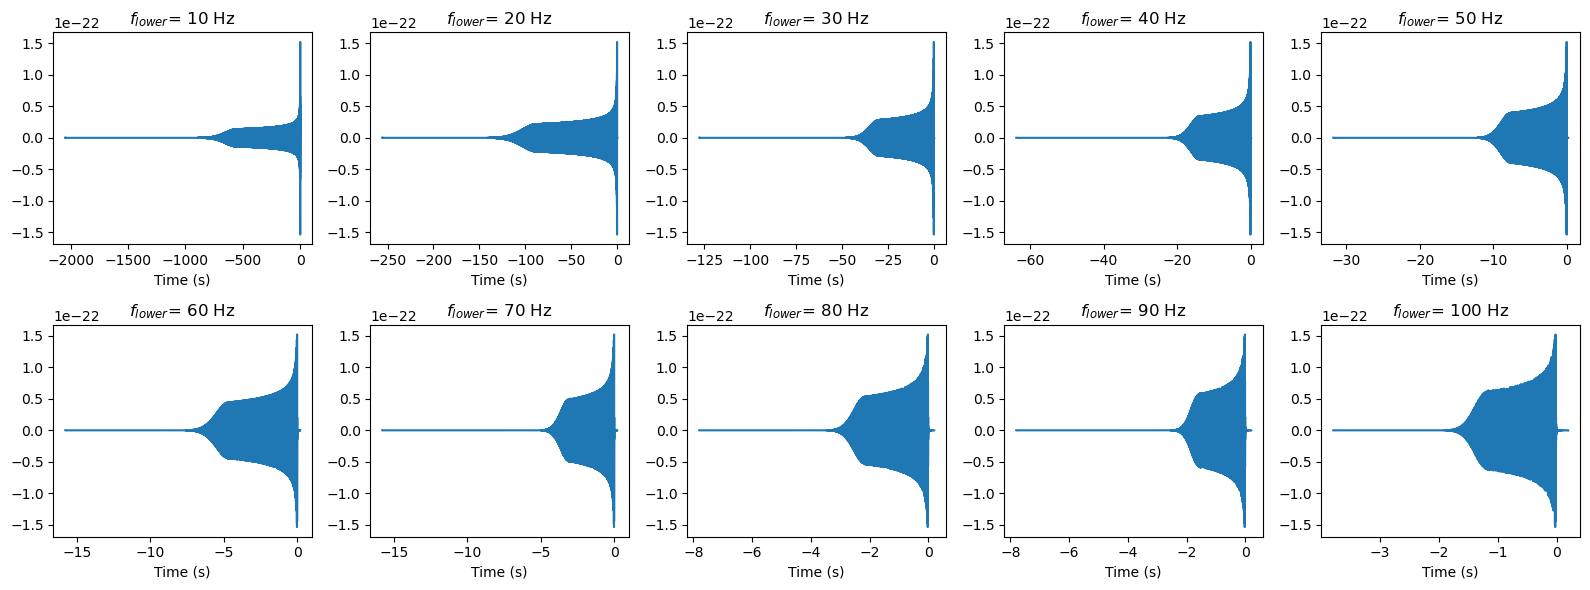

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(16, 6))
for ith_ax, ax in enumerate(axs.flatten()):
    ax.plot(hps[ith_ax].sample_times, hps[ith_ax])
    ax.set_title('$f_{lower}$' f'= {freqs[ith_ax]:.0f} Hz')
    ax.set_xlabel('Time (s)')
fig.tight_layout()

In [ ]:
len(hps[0]) / len(hps[9])

512.0

In [ ]:
for idx, hp in enumerate(hps):
    print(f"Freq: {int(freqs[idx]):3}. Starting time: {hp.sample_times[0]:7}, end time: {hp.sample_times[-1]:.2f}")

Freq:  10. Starting time: -2047.8, end time: 0.20
Freq:  20. Starting time:  -255.8, end time: 0.20
Freq:  30. Starting time:  -127.8, end time: 0.20
Freq:  40. Starting time:   -63.8, end time: 0.20
Freq:  50. Starting time:   -31.8, end time: 0.20
Freq:  60. Starting time:   -15.8, end time: 0.20
Freq:  70. Starting time:   -15.8, end time: 0.20
Freq:  80. Starting time:    -7.8, end time: 0.20
Freq:  90. Starting time:    -7.8, end time: 0.20
Freq: 100. Starting time:    -3.8, end time: 0.20


Okay, we can see that the starting time varies with the `f_lower` parameter. If this is set to a lower value, the simulation starts earlier, yielding a longer duration.  
In all cases, simulations end 0.2 seconds after the merger.

**ALERT:** In the plot, we see that the waveform "starts" (i.e. the amplitude becomes non-zero) at different times, depending on the frequency chosen.  

This is expected, as we are kind of applying a highpass filter. What is important is that, in our desired time window, the behaviour does not change.  
Below we try to see if this happens.

In [ ]:
def get_waveform_slice(waveform, begin=-1.0, end=0.2):
    x, y = np.arange(begin, end, waveform.delta_t), waveform.time_slice(begin, end)
    if len(x) > len(y):
        x = x[:-(len(x)-len(y))]
    return x, y

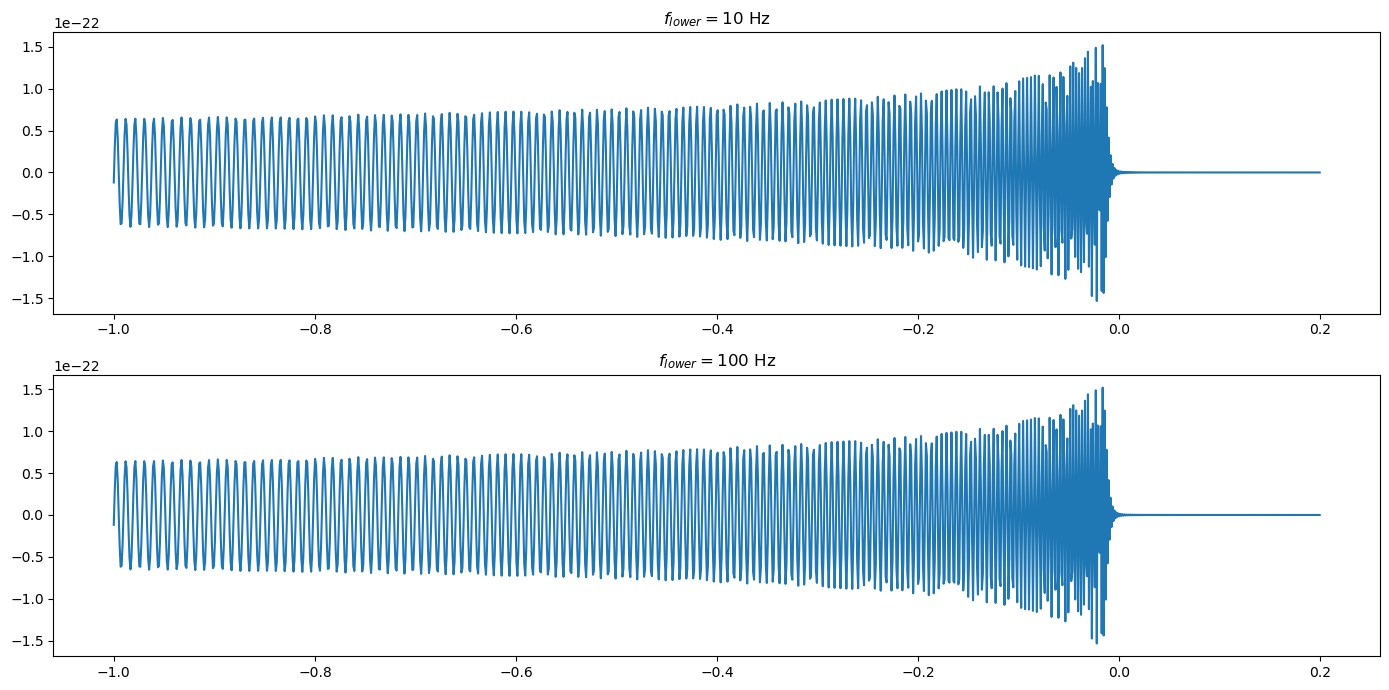

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(14, 7))
axs[0].plot(*get_waveform_slice(hps[0], begin=-1.0, end=0.2))
axs[0].set_title("$f_{lower} = $" f"{freqs[0]:.0f} Hz")
axs[1].plot(*get_waveform_slice(hps[9], begin=-1.0, end=0.2))
axs[1].set_title("$f_{lower} = $" f"{freqs[9]:.0f} Hz")
fig.tight_layout()

Above, we see that if we only care about the second before the merger, the waveform is equal whether we use a lower frequency of 10Hz or 100Hz, even tough in the previous plot the waveform corresponding to 10Hz "started" at 500 seconds before the merger and the one at 100Hz only about 2 seconds before.

**Conclusion:** We only need to check that the behaviour in the time window we want is equal for a wave generated with a low `f_lower` and the one we chose to speed up generation.
In our case of BNS mergers, 100 Hz still seems fine.

Another problem we observed above is that the waveforms don't look very good, with dips in the amplitude that are probably due to a low sampling rate.  
So let's increase the sampling to compare the waveforms.


In [ ]:
sampling_rates = np.array([512 * 2**i for i in range(6)])
sampling_rates

array([  512,  1024,  2048,  4096,  8192, 16384])

In [ ]:
config['freq_lower'] = 100
hps2 = []
for sampling_rate in sampling_rates:
    config['sample_rate'] = sampling_rate
    hp, _ = gen_data_strain(config)
    hps2.append(hp)

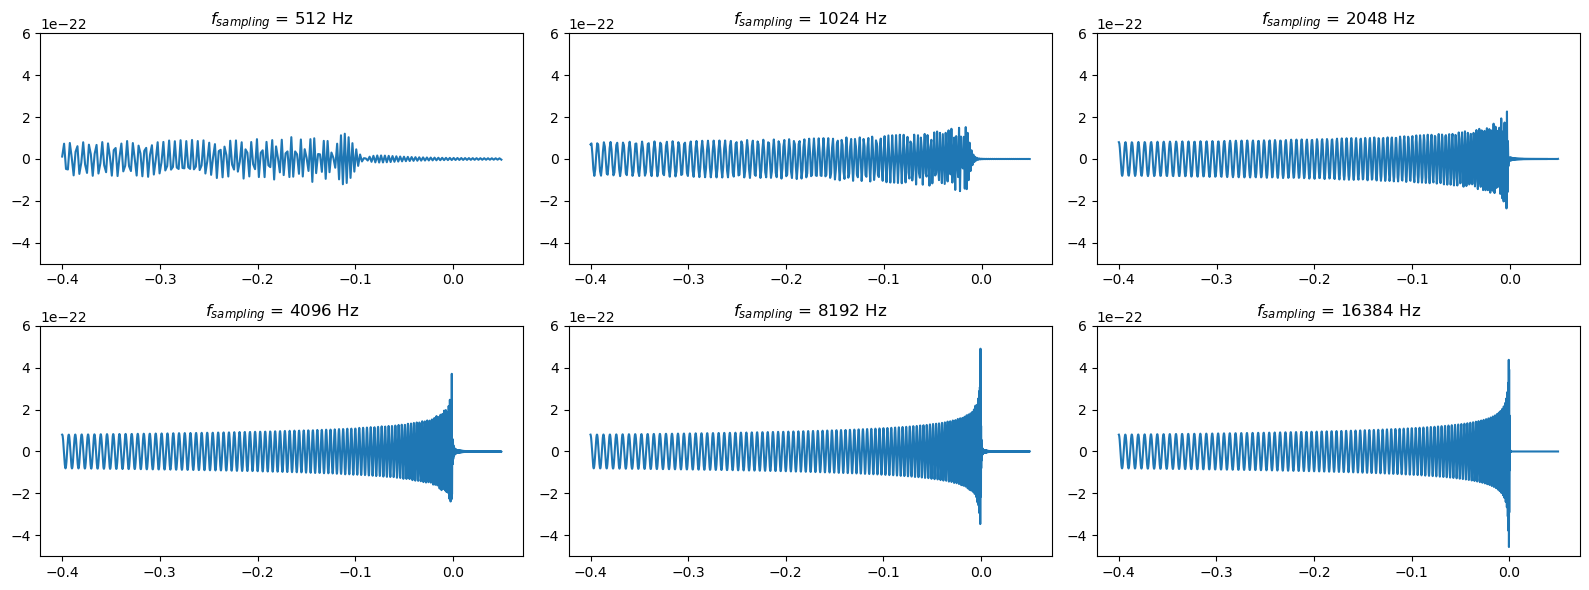

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(16, 6))
for ith_ax, ax in enumerate(axs.flatten()):
    ax.plot(*get_waveform_slice(hps2[ith_ax], begin=-0.4, end=0.05))
    ax.set_title('$f_{sampling}$' f' = {sampling_rates[ith_ax]} Hz')
    ax.set_ylim([-5e-22, 6e-22])
fig.tight_layout()

Waveforms only get decent at sampling rates higher than 4096Hz.  
Let's check these closer, with a narrower time window.

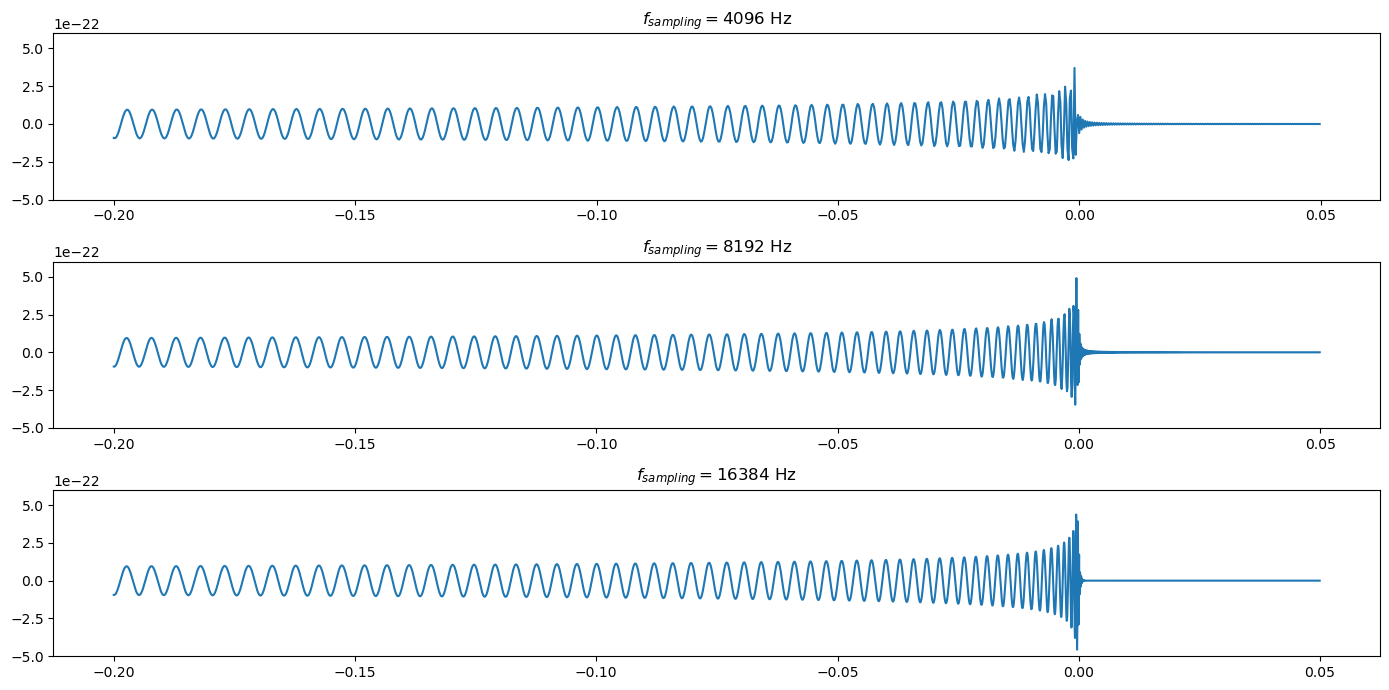

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(14, 7))
for ith_ax, ax in enumerate(axs.flatten()):
    axs[ith_ax].plot(*get_waveform_slice(hps2[ith_ax+3], begin=-0.2, end=0.05))
    axs[ith_ax].set_title("$f_{sampling} = $" f"{sampling_rates[ith_ax+3]:.0f} Hz")
for ax in axs: ax.set_ylim([-5e-22, 6e-22])
fig.tight_layout()

The lower sampling rates look weirder around the merger.  
Let's look even closer.

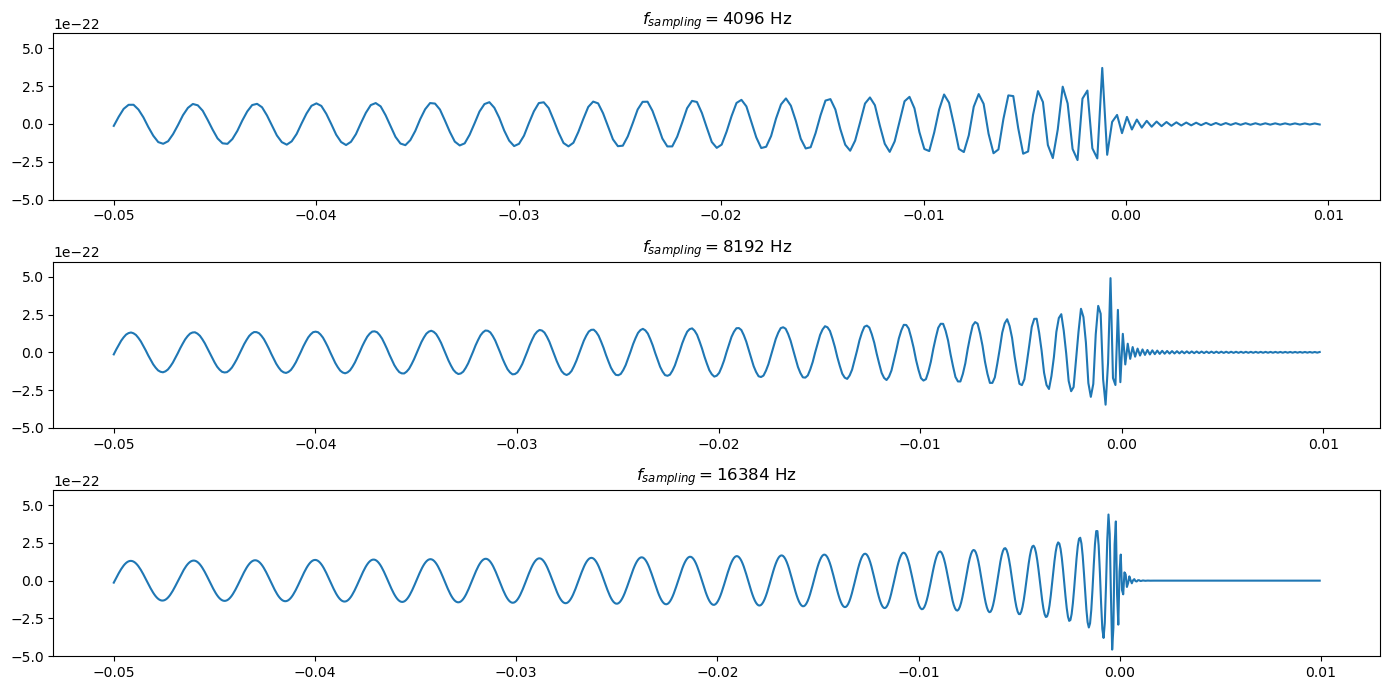

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(14, 7))
for ith_ax, ax in enumerate(axs.flatten()):
    axs[ith_ax].plot(*get_waveform_slice(hps2[ith_ax+3], begin=-0.05, end=0.01))
    axs[ith_ax].set_title("$f_{sampling} = $" f"{sampling_rates[ith_ax+3]:.0f} Hz")
for ax in axs: ax.set_ylim([-5e-22, 6e-22])
fig.tight_layout()

The minimum acceptable sampling frequency appears to be 8 kHz. But even in that case you see some artifacts.

**Conclusion:** Use sampling frequencies of 8kHz or above. The bigger the better.

Now let's go back to the study of the `f_lower` value, using the 16 kHz sampling rate.  
Maybe we can get `f_lower` even above the 100 Hz we have found to be fine.

In [ ]:
config['sample_rate'] = 1024*16
freqs = np.linspace(50, 140, 10)
freqs

array([ 50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140.])

In [ ]:
hps3 = []
for freq in freqs:
    config['freq_lower'] = freq
    hp, _ = gen_data_strain(config)
    hps3.append(hp)

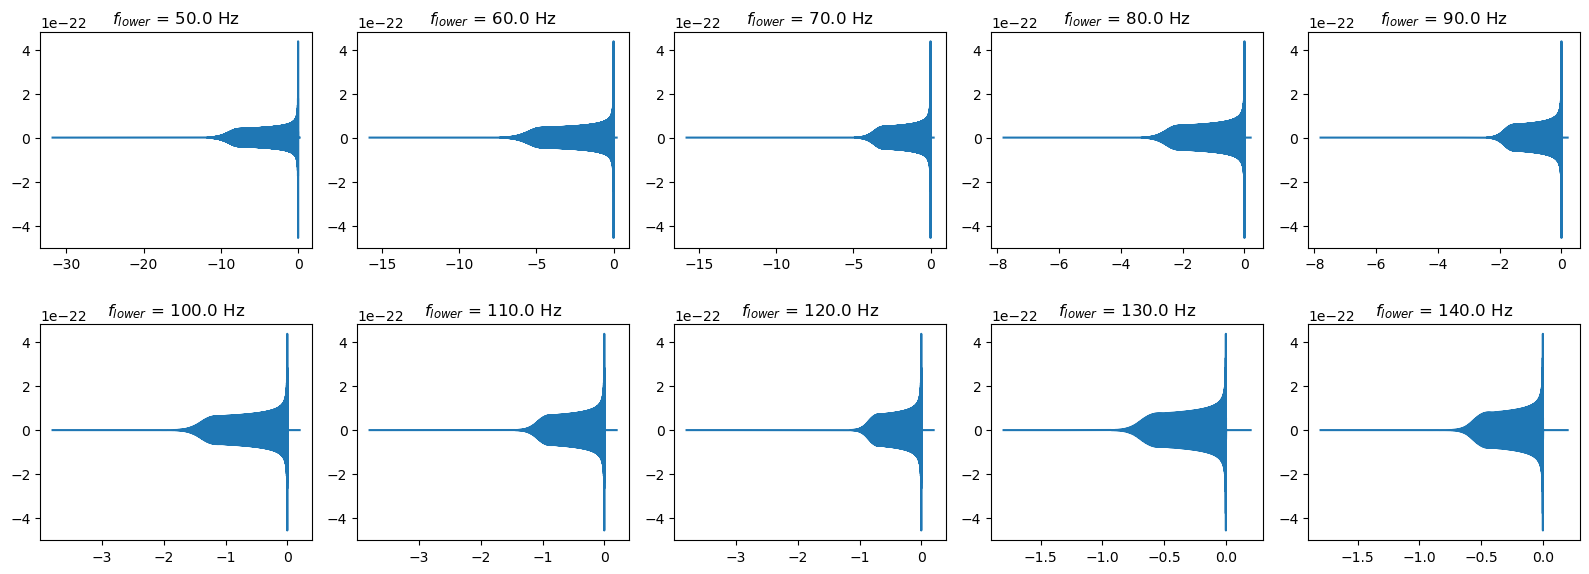

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(16, 6))
for ith_ax, ax in enumerate(axs.flatten()):
    ax.plot(hps3[ith_ax].sample_times, hps3[ith_ax])
    ax.set_title('$f_{lower}$' f' = {freqs[ith_ax]} Hz')
fig.tight_layout()

We see that with higher frequencies, the window of 1 second before the merger starts to be changed.  
In fact, 100 Hz appears to be dangerously close to the limit.  
Let's check the cases around it in more detail.

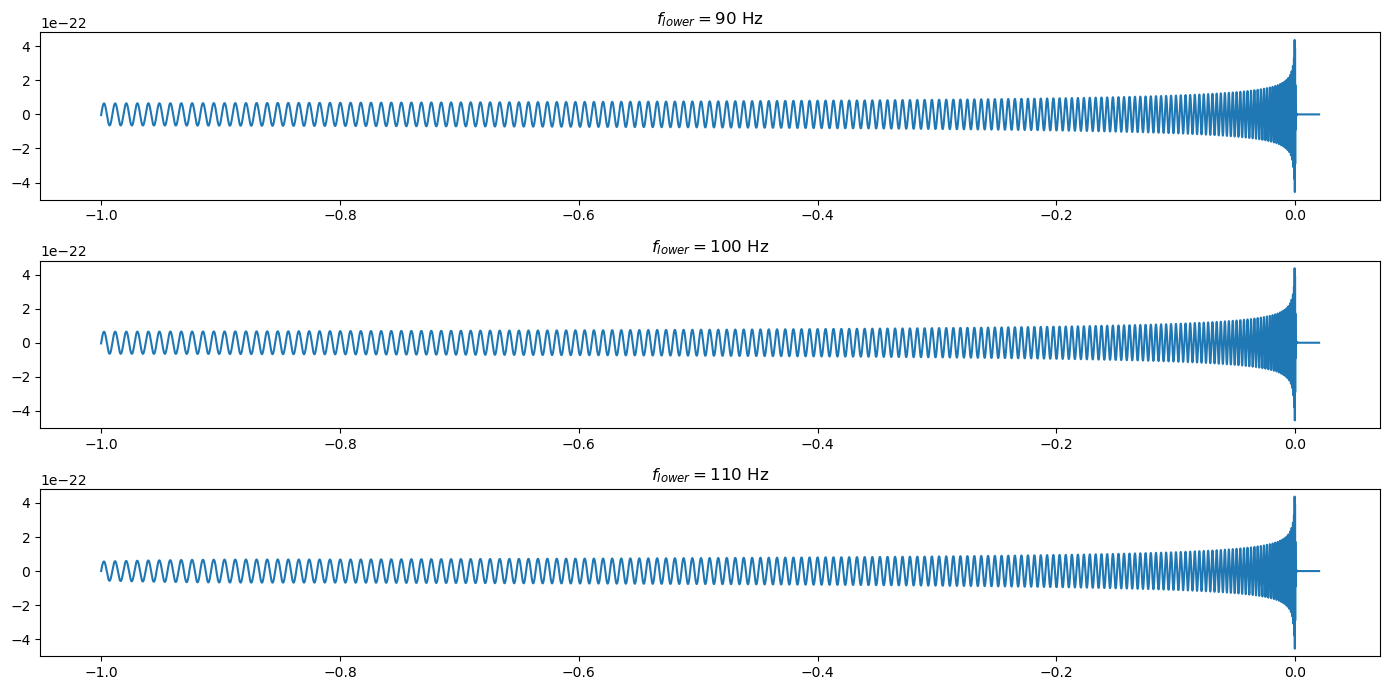

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(14, 7))
for ith_ax, ax in enumerate(axs.flatten()):
    axs[ith_ax].plot(*get_waveform_slice(hps3[ith_ax+4], end=0.02))
    axs[ith_ax].set_title("$f_{lower} = $" f"{freqs[ith_ax+4]:.0f} Hz")
for ax in axs: ax.set_ylim(axs[0].get_ylim())
fig.tight_layout()

One last check. Let's see if the values are really the same.

In [ ]:
from lal import LIGOTimeGPS

print('Amplitude values at different instants:')
for i, hp in enumerate(hps3):
    print(f'f_s = {freqs[i]:3.0f} Hz. -1.0 s: {hp.at_time(LIGOTimeGPS(-1.0)): 8.2e}, '
          +f'-0.5 s: {hp.at_time(LIGOTimeGPS(-0.5)): 8.2e}, -0.25 s: {hp.at_time(LIGOTimeGPS(-0.25)): 8.2e}')

Amplitude values at different instants:
f_s =  50 Hz. -1.0 s: -4.07e-24, -0.5 s: -3.51e-23, -0.25 s: -1.59e-23
f_s =  60 Hz. -1.0 s: -4.07e-24, -0.5 s: -3.51e-23, -0.25 s: -1.59e-23
f_s =  70 Hz. -1.0 s: -4.07e-24, -0.5 s: -3.51e-23, -0.25 s: -1.59e-23
f_s =  80 Hz. -1.0 s: -4.07e-24, -0.5 s: -3.51e-23, -0.25 s: -1.59e-23
f_s =  90 Hz. -1.0 s: -4.07e-24, -0.5 s: -3.51e-23, -0.25 s: -1.59e-23
f_s = 100 Hz. -1.0 s: -3.92e-24, -0.5 s: -3.51e-23, -0.25 s: -1.59e-23
f_s = 110 Hz. -1.0 s:  3.69e-25, -0.5 s: -3.52e-23, -0.25 s: -1.59e-23
f_s = 120 Hz. -1.0 s: -2.90e-24, -0.5 s: -3.52e-23, -0.25 s: -1.59e-23
f_s = 130 Hz. -1.0 s:  3.11e-26, -0.5 s: -3.54e-23, -0.25 s: -1.59e-23
f_s = 140 Hz. -1.0 s:  5.06e-27, -0.5 s: -2.71e-23, -0.25 s: -1.59e-23


**Conclusion:** If we want the whole second before merger, the maximum sampling frequency we could use is 90 Hz.  
But for the last half second we could go as high as 100 Hz and for the last 0.25s all frequencies seem to work fine.

Now, we move to the time considerations.

Let's start with the parameters we found to be the best.

In [ ]:
config = {
    'approximant': "IMRPhenomPv2",
    'mass1': 2.0,
    'mass2': 2.0,
    'distance': 100,
    'inclination': 0.0,
    'sample_rate': 1024 * 16,
    'freq_lower': 90
}

In [ ]:
%%timeit
hp, hc = gen_data_strain(config)

85.8 ms ± 6.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
import time

def timeit(func, params, n_runs=7):
    times = np.array([])
    for i in range(7):
        start_time = time.time()
        func(*params)
        end_time = time.time()
        times = np.append(times, end_time - start_time)
    return times.mean()

About 85 milliseconds for waveform.  
This gives 850 seconds (a little less than 15 min) to generate a dataset of 10k waveforms. Doable.

Anyway, let's see how `freq_lower` and `sample_rate` affect our time.  
We'll start with `freq_lower`.

In [ ]:
freq_lowers = np.linspace(10, 150, 15)
freq_lowers

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110.,
       120., 130., 140., 150.])

In [ ]:
times = []
for freq_lower in freq_lowers:
    config['freq_lower'] = freq_lower
    ex_time = timeit(gen_data_strain, [config])
    times.append(ex_time)

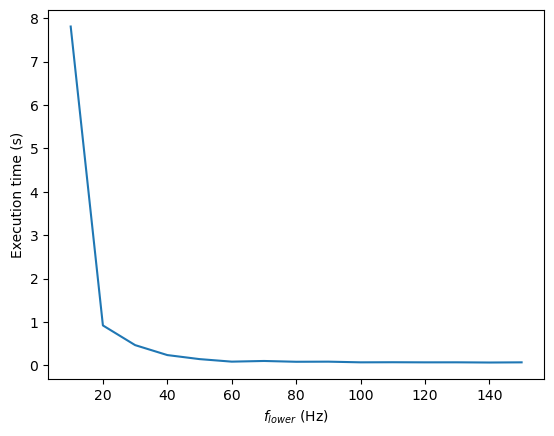

In [ ]:
plt.plot(freq_lowers, times)
plt.xlabel('$f_{lower}$ (Hz)')
plt.ylabel('Execution time (s)');

**Conclusion:** Every frequency above 50 Hz seems fine regarding the execution time.

Finally, let's test for sample rate.

In [ ]:
config = {
    'approximant': "IMRPhenomPv2",
    'mass1': 2.0,
    'mass2': 2.0,
    'distance': 100,
    'inclination': 0.0,
    'sample_rate': None,
    'freq_lower': 90
}

In [ ]:
sample_rates = np.array([256 * 2**i for i in range(8)])
sample_rates

array([  256,   512,  1024,  2048,  4096,  8192, 16384, 32768])

In [ ]:
times = []
for sample_rate in sample_rates:
    config['sample_rate'] = sample_rate
    ex_time = timeit(gen_data_strain, [config], n_runs=31)
    times.append(ex_time)

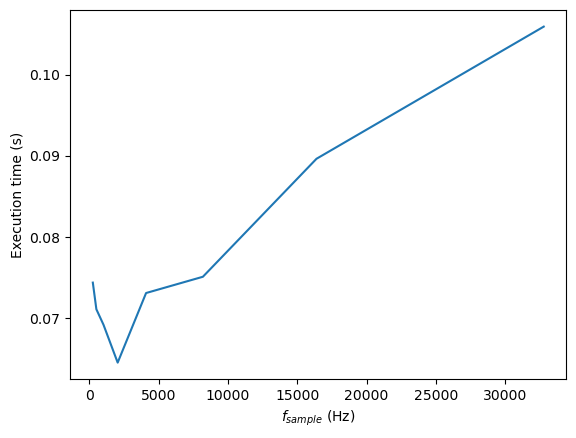

In [ ]:
plt.plot(sample_rates, times)
plt.xlabel('$f_{sample}$ (Hz)')
plt.ylabel('Execution time (s)');

In [ ]:
from scipy.stats import linregress

lr = linregress(sample_rates, times)
lr.slope, lr.intercept

(1.1457863106030417e-06, 0.06850319058016312)

The execution time grows linearly with the sample rate, buth the slope is very low.  
The most important factor is, without doubt, `f_lower`.

**Conclusion:** We can set the sample rate to any value we want to without fear of increasing the computational cost of the simulations.